<a href="https://colab.research.google.com/github/ktoprakucar/fine-tuning-turkish-bert-model/blob/master/classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

koda geçmeden önce, koddaki BERT ile ilgili olan kısımları https://mccormickml.com/2019/07/22/BERT-fine-tuning/ linkindeki kodlardan yararlanarak oluşturduğumu belirtmek isterim

In [1]:
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from google.colab import drive

!pip install transformers
import transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# check GPU
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla P100-PCIE-16GB


dosyayı drive'dan okuyabilmeniz için google drive'daki ana klasörünüze resource isminde bir klasör oluşturup, kaggle'dan indirdiğimiz dosyayı *turkish_text_data*.csv olarak kaydetmemiz gerekiyor.

kaggle data'sını linkten indirebilirsiniz: https://www.kaggle.com/savasy/ttc4900

In [3]:
# set environment as googledrive to folder "resource"
data_path =  "/resource/"

try:
    drive.mount('/content/drive')
    data_path = "/content/drive/My Drive/resource/"

except:
    print("You are not working in Colab at the moment :(")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv(data_path + 'turkish_text_data.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 0 to 4899
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  4900 non-null   object
 1   text      4900 non-null   object
dtypes: object(2)
memory usage: 76.7+ KB


In [6]:
df.sample(10)

,category,text
808,dunya,berdimuhamedov ermenistan ı ziyaret edecek tü...
3029,saglik,koah aids kadar tehlikeli söz konusu hastalık...
3545,spor,webo carvalhal den izin istedi geçen sezon is...
2632,kultur,büyük ev abluka dan ilk albüm bugün kadar ver...
4785,teknoloji,facebook ta yeni dönem sosyal ağ devi faceboo...
1074,dunya,maske takana 10 yıl hapis kanada da herhangi ...
4714,teknoloji,nasa nın iki uzay aracı emekli oldu nasa ya a...
720,dunya,kosova ya türkiye den destek dışişleri_bakanl...
3997,spor,beşiktaş seri peşinde spor_toto_süper_lig in ...
4459,teknoloji,dünya dışındaki yaşamı dünyada arıyorlar bili...


In [7]:
df.groupby('category').size()

category
dunya         700
ekonomi       700
kultur        700
saglik        700
siyaset       700
spor          700
teknoloji     700
dtype: int64

Kategorik olan label'ları modelde kullanabilmemiz için kategori kolonunu encode etmemiz gerekiyor.

In [0]:
df['encoded_categories'] = LabelEncoder().fit_transform(df['category'])

Bert için gerekli olan 2 ana objeyi, tokenizer'ı ve model'i hugging face'ten indirebilirsiniz: https://huggingface.co/models

tokenizer'ı, önceden sahip olunan kelime haznesine kullanarak metinini ögelerini ayırma işleminde kullanılan araç olarak tanımlayabiliriz. bu tokenizer'daki kelimelere aşağıdaki linkten ulaşabilirsiniz: 
https://s3.amazonaws.com/models.huggingface.co/bert/dbmdz/bert-base-turkish-128k-uncased/vocab.txt

In [0]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-turkish-128k-uncased', do_lower_case=True)

In [0]:
sentences = df.text.values

In [0]:
max_len = 250

burada elimizdeki metin verisini %80 ve %20 oranıyla, sırasıyla training ve test olarak ikiye bölüyoruz

In [0]:
training = df.groupby('category').apply(lambda x : x.sample(frac = 0.8))
test = pd.concat([df,training]).drop_duplicates(keep=False)

In [13]:
print("Training: ", len(training))
print("Test: ", len(test))

Training:  3920
Test:  838


In [0]:
training_texts = training.text.values
training_labels = training.encoded_categories.values

bu kısımda metin verisini modelde kullanmak üzere işliyoruz. öncelikle cümledeki kelimeler indirdiğimiz tokenizer ile tokenize ediliyor, sonrasında sınıflandırma probleminin çözülebilmesi için gerekli olan token'lar cümlenin sonuna ve başına ekleniyor. cümle maksimum uzunluktan kısaysa, input vektörümüz sabit uzunlukta olduğu için boşluklar dolduruluyor, uzunsa metin limit kadar kelime ile ifade ediliyor. attention mask'leri oluşturuluyor ve metinler işlemin sonucunda tensor objesi olarak geri dönüyor.

aşağıdaki çıktıda da görüldüğü üzere, metindeki kelimeler tokenizer'daki kelimelerin id'leri ile ifade ediliyor ve bu şekilde işleme sokuluyor.

In [15]:
input_ids = []
attention_masks = []

for text in training_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True,
                        max_length = max_len,      
                        pad_to_max_length = True,
                        return_attention_mask = True, 
                        return_tensors = 'pt',
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(training_labels)

print('Original: ', training_texts[0])
print('Token IDs:', input_ids[0])

Original:   ankara obama ya sıcak abd seçmeni bugün yalnız kendi kaderine değil dünyanın kaderine yön verecek ankara 4 yıldır birçok konuda görüş birliği içinde olduğu obama ya daha yakın mahmut_gürer / ankara dünyanin gözü bugün washington da olacak ankara da süreci yakından izliyor ancak daha önceki abd başkanlık seçimlerinden farklı olarak bu kez kaygı seviyesi en alt düzeyde bunun nedeni ise her iki adayın da dış politika projeksiyonunun ankara ya ters bir noktasının bulunmaması diplomatik kaynaklara göre ankara mevcut başkan barack_obama ile yaklaşık 4 yıldır oldukça yakın çalışıyor bu süre içerisinde özellikle terörle mücadele istihbarat ortaklığı ortadoğu gibi konularda çok yakın işbirliği sağlandı ankara obama nın seçilmesi durumunda ilişkilerin aynı şekilde devam etmesini öngörüyor bu nedenle abd halkının obama yı tercih etmesi istemi ankara da daha ağır basıyor ankara nın bu yaklaşımının temel nedenini ise obama ile yürütülen stratejik ve model ortaklık politikasının devamı o

In [0]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

oluşturduğumuz tensor verisini modele vermek üzere *dataloader* değişkenine dönüştürüyoruz. 

In [0]:
batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )

In [0]:
number_of_categories = len(df['encoded_categories'].unique())

tokenizer'da olduğu gibi, önceden train edilmiş olan modeli fine tune etmek için hugging face'ten indiriyoruz. modelin özelliklerine aşağıdaki linkten ulaşabilirsiniz: 
https://s3.amazonaws.com/models.huggingface.co/bert/dbmdz/bert-base-turkish-128k-uncased/config.json

In [19]:
model = BertForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-128k-uncased",
    num_labels = number_of_categories, 
    output_attentions = False,
    output_hidden_states = False,
)

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(128000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

training'den önceki son adımda, toplam training adım sayısını ve kaç kere training yapılacağı sayısını belirliyoruz. bu sayıların yanında, öğrenmenin daha verimli olabilmesi ve *learning rate* optimizasyonu için bir scheduler yaratılıyor ve optimizer olarak *Adam Optimizer* kullanılıyor.

In [0]:
epochs = 4

optimizer = AdamW(model.parameters(),
                  lr = 5e-5,
                  eps = 1e-8 
                )

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [0]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [22]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

seed_val = 1903

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    t0 = time.time()
    total_train_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 10 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    training_time = format_time(time.time() - t0)

    print("Average training loss: {0:.2f}".format(avg_train_loss))
    print("Training epoch took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time,
        }
    )

print("Training completed in {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

======== Epoch 1 / 4 ========
Batch    10  of    123.    Elapsed: 0:00:08.
Batch    20  of    123.    Elapsed: 0:00:15.
Batch    30  of    123.    Elapsed: 0:00:23.
Batch    40  of    123.    Elapsed: 0:00:31.
Batch    50  of    123.    Elapsed: 0:00:39.
Batch    60  of    123.    Elapsed: 0:00:46.
Batch    70  of    123.    Elapsed: 0:00:54.
Batch    80  of    123.    Elapsed: 0:01:02.
Batch    90  of    123.    Elapsed: 0:01:10.
Batch   100  of    123.    Elapsed: 0:01:17.
Batch   110  of    123.    Elapsed: 0:01:25.
Batch   120  of    123.    Elapsed: 0:01:33.
Average training loss: 0.51
Training epoch took: 0:01:35
======== Epoch 2 / 4 ========
Batch    10  of    123.    Elapsed: 0:00:08.
Batch    20  of    123.    Elapsed: 0:00:15.
Batch    30  of    123.    Elapsed: 0:00:23.
Batch    40  of    123.    Elapsed: 0:00:31.
Batch    50  of    123.    Elapsed: 0:00:39.
Batch    60  of    123.    Elapsed: 0:00:46.
Batch    70  of    123.    Elapsed: 0:00:54.
Batch    80  of    123.    E

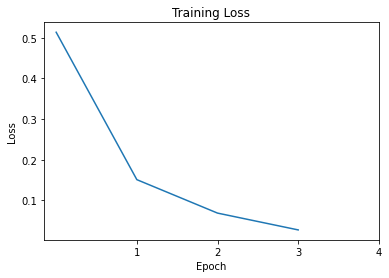

In [23]:
df_stats = pd.DataFrame(data=training_stats)
plt.plot(df_stats['Training Loss'], label="Training")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4])
plt.show()

In [0]:
test_texts = test.text.values
test_labels = test.encoded_categories.values

input_ids = []
attention_masks = []

for text in test_texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                     
                        add_special_tokens = True, 
                        max_length = max_len,          
                        pad_to_max_length = True,
                        return_attention_mask = True,  
                        return_tensors = 'pt',   
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)

batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [25]:
print('Prediction started on test data')
model.eval()
predictions , true_labels = [], []

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  predictions.append(logits)
  true_labels.append(label_ids)

print('Prediction completed')

Prediction started on test data
Prediction completed


In [0]:
prediction_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

In [0]:
f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')

In [28]:
print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)

F-Score:  0.91992270045502
Recall:  0.9210612904649649
Precision:  0.9196331265833295


In [0]:
report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))

In [0]:
report = report.rename(columns={'0':'dunya',
                          '1':'ekonomi',
                          '2':'kultur',
                          '3':'saglik',
                          '4':'siyaset',
                          '5':'spor',
                          '6':'teknoloji'})

In [31]:
report

,dunya,ekonomi,kultur,saglik,siyaset,spor,teknoloji,accuracy,macro avg,weighted avg
precision,0.936000,0.873016,0.963855,0.930435,0.910448,0.959016,0.864662,0.916468,0.919633,0.916409
recall,0.893130,0.820896,0.952381,0.963964,0.897059,1.000000,0.920000,0.916468,0.921061,0.916468
f1-score,0.914063,0.846154,0.958084,0.946903,0.903704,0.979079,0.891473,0.916468,0.919923,0.915993
support,131.000000,134.000000,84.000000,111.000000,136.000000,117.000000,125.000000,0.916468,838.000000,838.000000
